In [1]:
import numpy as np
import random as rn
import os 
from numpy.random import randint
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colorbar
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from typing import NoReturn, Text
import warnings
import time
# import pyvista as pv
# from scipy.signal import find_peaks
from celluloid import Camera
from datetime import datetime

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)
# pv.set_plot_theme("document")
%matplotlib inline

from scipy.spatial import Voronoi
import matplotlib.pyplot as plt
from geovoronoi import voronoi_regions_from_coords
from geovoronoi import polygon_lines_from_voronoi
import shapely
from shapely.geometry import Point
from shapely.geometry import MultiPolygon
from shapely.geometry import Polygon
from descartes import PolygonPatch
import numpy as np
from shapely.geometry.polygon import LinearRing, Polygon
# import pyvista as pv
from matplotlib import cm

In [2]:
#import local scripts
from Agent import Agent
from Model import Model
from Grid import Grid

In [3]:
## Set seed for random generation
def seed_everything(seed : int) -> NoReturn :
    """To set the see for all potential random number usages. If you are using 
    any other package which might use seed for random generation add it here"""
    rn.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #tf.random.set_seed(seed)  ##uncomment if you are using tensorflow
    
SEED = 123123
seed_everything(SEED)

In [4]:

### set parameters 
TURNS = 10
RATIOTRACKEDAGENTS = 1.
all_vals_len = 200*100
TI_zone = np.zeros((all_vals_len,4))
TI_zone[:10000,2] = 0
TI_zone[10000:,2] = 1
TI_zone[15000:,2] = 2
TI_zone[:3000,2] = 3
TI_zones = TI_zone[:,2].reshape((200,100,1))
# preference_L = [[[2., 1., 0.],[2., 1., 0.], [2., 1., 0.]],
#             [[2., 1., 0.], [3., 0., 0.], [2., 1., 0.]],
#             [[2., 1., 0.], [2., 1., 0.], [2., 1., 0.]]]
# PREFERENCE_MATRIX = np.array([np.array(np.array([Lii for Lii in Li])) for Li in preference_L])

# stochastic_L = [[[0.075, 0.0375, 0.], [0.075, 0.0375, 0.], [0.075, 0.0375, 0.]],
#             [[0.075, 0.0375, 0.], [0.1, 0., 0.], [0.075, 0.0375, 0.]],
#             [[0.075, 0.0375, 0.], [0.075, 0.0375, 0.], [0.075, 0.0375, 0.]]]
# STOCHASTIC_MATRIX = np.array([np.array(np.array([Lii for Lii in Li])) for Li in stochastic_L])










In [5]:

t1 = time.time()

model = Model(env = TI_zones, 
              number_of_turns=TURNS, number_of_starting_agents = 5,new_agent_every_n_turns = 2,new_agents_per_n_turns = 1,max_number_agents = 250,
              ratio_of_tracked_agents = 1.,number_training_image_zones = 2, number_training_images_per_zone = 20
             )
model.run()
print("Simulation took {0:2.2f} seconds".format(time.time()-t1))
test_df =model.get_final_results()
print(test_df.head(20))

Shape of your environment: (200, 100, 1)
=======Initiating grid=========
Grid initiated! -  took 0.00 seconds
generated new agent
generated new agent
generated new agent
generated new agent
generated new agent
=======Turn 0========
Moving agents done                  
Generating agents done              
=======Turn 1========
Moving agents done                  
Generating agents done              
=======Turn 2========
generated new agent
Moving agents done                  
Generating agents done              
=======Turn 3========
Moving agents done                  
Generating agents done              
=======Turn 4========
generated new agent
Moving agents done                  
Generating agents done              
=======Turn 5========
Moving agents done                  
Generating agents done              
=======Turn 6========
generated new agent
Moving agents done                  
Generating agents done              
=======Turn 7========
Killed agent 5        
agents in act

In [6]:
tracker = model.get_all_tracks()
tracker

array([[[ 26.,  44.,   0.,   0.],
        [ 26.,  44.,   0.,   0.],
        [ 25.,  45.,   0.,   0.],
        [ 26.,  46.,   0.,   0.],
        [ 25.,  47.,   0.,   0.],
        [ 26.,  46.,   0.,   1.],
        [ 27.,  46.,   0.,   1.],
        [ 26.,  45.,   0.,   2.],
        [ 26.,  46.,   0.,   1.],
        [ 25.,  47.,   0.,   2.],
        [ 24.,  46.,   0.,   0.]],

       [[ 13.,  98.,   0.,   2.],
        [ 14.,  99.,   0.,   2.],
        [ 15.,  99.,   0.,   2.],
        [ 15.,  98.,   0.,   3.],
        [ 15.,  99.,   0.,   3.],
        [ 15.,  99.,   0.,   2.],
        [ 15.,  98.,   0.,   2.],
        [ 15.,  99.,   0.,   2.],
        [ 14.,  99.,   0.,   2.],
        [ 13.,  99.,   0.,   2.],
        [ 12.,  99.,   0.,   2.]],

       [[193.,  87.,   0.,   0.],
        [194.,  87.,   0.,   0.],
        [195.,  88.,   0.,   0.],
        [196.,  87.,   0.,   2.],
        [197.,  88.,   0.,   2.],
        [197.,  87.,   0.,   0.],
        [197.,  87.,   0.,   0.],
        [1

In [7]:
iteration=[]
for turns in range(TURNS+1):
    agent_pos = []
    for agent_id in range(model.current_id+1):
        agent_pos.append(tracker[agent_id][turns][0:4])
    
    iteration.append(agent_pos)
iteration = np.array(iteration)


In [8]:
N = 50
# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
viridis = cm.get_cmap('jet', 5)
viridis(3)

(1.0, 0.5925925925925927, 0.0, 1.0)

In [9]:
grid = Polygon([(0, 0), (0, 100), (200, 100), (200, 0)])


(0.0, 100.0)

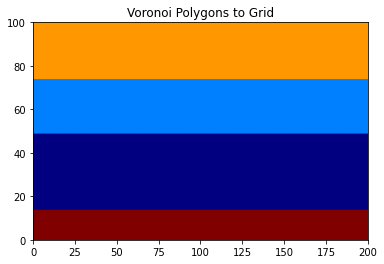

In [10]:
# generate 2D mesh
x = np.arange(0,200+1,1,)
y = np.arange(0,100+1,1)
x_grid, y_grid = np.meshgrid(x,y)
# get cell center
x_cell_center = x_grid[:-1,:-1]+0.5
y_cell_center = y_grid[:-1,:-1]+0.5
cell_center_which_polygon = np.zeros(len(x_cell_center.flatten()))
which_TI_zone = np.zeros(len(x_cell_center.flatten()))
# array to assign polygon to cell id
all_cell_center = np.column_stack((x_cell_center.flatten(),y_cell_center.flatten(),cell_center_which_polygon,which_TI_zone))
plt.scatter(x_cell_center,y_cell_center, c = TI_zone[:,2],cmap=viridis)
plt.title("Voronoi Polygons to Grid")
plt.xlim([0,200])
plt.ylim([0,100])

In [11]:
# in what voronoi polygon do cell centers plot
for i in range(len(all_cell_center)):
    for voronoi_polygon_id in range(len(poly_shapes)):
        
        polygon = poly_shapes[voronoi_polygon_id]
        cell_id = Point(all_cell_center[i,0],all_cell_center[i,1])
        
        if polygon.intersects(cell_id):
            all_cell_center[i,2] = voronoi_polygon_id

plt.scatter(x_cell_center,y_cell_center, c = all_cell_center[:,2])
plt.title("Voronoi Polygons to Grid")
plt.xlim([0,200])
plt.ylim([0,100])


NameError: name 'poly_shapes' is not defined

In [12]:
len(poly_shapes)

NameError: name 'poly_shapes' is not defined

NameError: name 'zone' is not defined

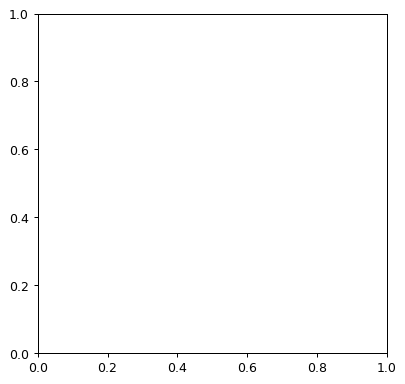

In [13]:
fig = plt.figure(1, figsize=(5,5), dpi=90)
color = ["red","blue","green","black"]#,"yellow","red","blue","green","black","yellow","red","blue","green","black","yellow"]
# color = 100*np.random.randint(n_voronoi)
N = 15
# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = np.linspace(0,N,N+1)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
ax = fig.add_subplot(111)
# for i in range(len(poly_shapes)):
for i in range(1):
    TI_id = int(zone[i])
    ring_patch = PolygonPatch(poly_shapes[i], facecolor = color[TI_id])# viridis(TI_id))
    ax.add_patch(ring_patch)
    ax.set_title('Voronoi tesselation')
    xrange = [0, 200]
    yrange = [0, 100]
    ax.set_xlim(*xrange)
    ax.set_ylim(*yrange)
    ax.set_aspect(1)


# plt.xlim([0,10])
# plt.ylim([0,10])

In [14]:
tracker[0][0]

array([26., 44.,  0.,  0.])

In [15]:
zone
# len(poly_shapes)

NameError: name 'zone' is not defined

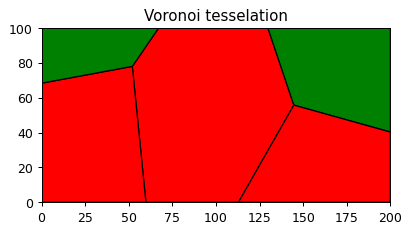

In [16]:
iter_to_display = 2
# extract voronoi point and TI_zone affiliated with them
voronoi_points = np.vstack((iteration[iter_to_display][:,0],iteration[iter_to_display][:,1])).T
voronoi_points = voronoi_points[~np.isnan(voronoi_points).any(axis=1)]

zone = iteration[iter_to_display][:,3]
zone = zone[~np.isnan(zone)]
# zone[-1]=zone[-2]
# get voronoi regions
poly_shapes, pts, poly_to_pt_assignments = voronoi_regions_from_coords(voronoi_points, grid)

fig = plt.figure(1, figsize=(5,5), dpi=90)
# color = ["red","blue","green","black","yellow","red","blue","green","black","yellow","red","blue","green","black","yellow"]
# color = 100*np.random.randint(len(voronoi_points))
# viridis = cm.get_cmap('viridis', model.current_id+1)

ax = fig.add_subplot(111)
for j in range(len(poly_shapes)):
    TI_id = int(zone[j])
    ring_patch = PolygonPatch(poly_shapes[j], facecolor =  color[TI_id])
    ax.add_patch(ring_patch)
    ax.set_title('Voronoi tesselation')
    xrange = [0, 200]
    yrange = [0, 100]
    ax.set_xlim(*xrange)
    ax.set_ylim(*yrange)
    ax.set_aspect(1)



In [17]:
zone

array([0., 2., 0., 2., 0.])

In [18]:
%matplotlib notebook
%matplotlib notebook

<IPython.core.display.Javascript object>


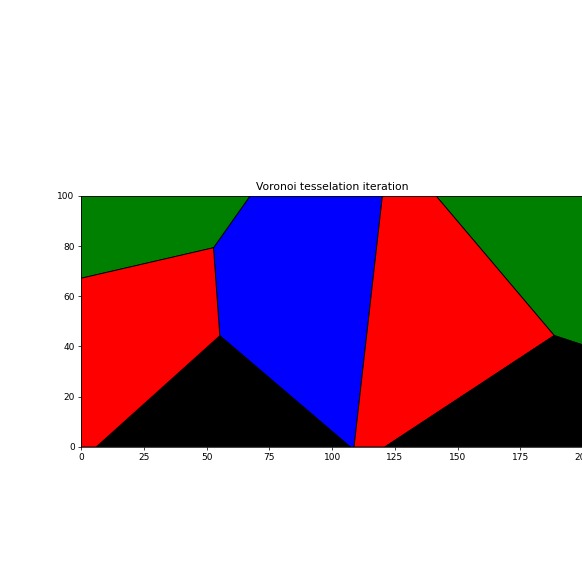

In [19]:
fig = plt.figure(figsize = (10,10))
camera = Camera(fig)
for i in range(TURNS+1):
    # extract voronoi points and TI_zone affiliated with them
    voronoi_points = np.vstack((iteration[i][:,0],iteration[i][:,1])).T
    voronoi_points = voronoi_points[~np.isnan(voronoi_points).any(axis=1)]

    zone = iteration[i][:,3]
    zone = zone[~np.isnan(zone)]

    # get voronoi regions
    poly_shapes, pts, poly_to_pt_assignments = voronoi_regions_from_coords(voronoi_points, grid)

    fig = plt.figure(1, figsize=(5,5), dpi=90)
#     color = ["red","blue","green","black","yellow","red","blue","green","black","yellow","red","blue","green","black","yellow"]
#     color = 100*np.random.randint(len(voronoi_points))
    viridis = cm.get_cmap('jet', 12)

    ax = fig.add_subplot(111)
    for j in range(len(poly_shapes)):
        TI_id = zone[j]
        ring_patch = PolygonPatch(poly_shapes[j], facecolor =  color[int(TI_id)])
        ax.add_patch(ring_patch)
        ax.set_title('Voronoi tesselation iteration')
        xrange = [0, 200]
        yrange = [0, 100]
        ax.set_xlim(*xrange)
        ax.set_ylim(*yrange)
        ax.set_aspect(1)


    # plt.xlim([0,10])
    # plt.ylim([0,10])
    camera.snap()
animation = camera.animate()

In [21]:
### Save the animated plot as GIF ###

import matplotlib.animation as mpl_anim

# Set up formatting for the movie files
Writer = mpl_anim.PillowWriter
writer = Writer(fps=4, metadata=dict(artist='Steffens'), bitrate=1800)


animation.save('animated_2D_plot.gif', writer=writer)